## Example: Portfolio Allocation Drift with Passive Management
Fill me in

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


In [2]:
include(joinpath(_PATH_TO_SRC, "CHEME-5660-L15a-PortfolioDriftPassive-CodeLibrary.jl"));

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `11-17-2023`, along with data for a few exchange traded funds and volatility products during that time. 

In [3]:
original_dataset = load(joinpath(_PATH_TO_DATA, 
        "SP500-Daily-OHLC-1-3-2018-to-11-17-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array:

In [6]:
all_tickers = keys(dataset) |> collect |> sort;
K = length(all_tickers);

### Get the 2023 `SPY` data

In [7]:
startdate = Date(2023,01,03);
SPY_dataset = dataset["SPY"];
SPY_df = filter(:timestamp => x-> x >= startdate, SPY_dataset);

## Task 1: Load Efficient Frontier and Select a Portfolio

In [8]:
efficient_frontier = load(joinpath(_PATH_TO_DATA,
        "EfficientFrontier-PortfolioDriftExample-PD1-CHEME-5660-Fall-2023.jld2")) |> x->x["dataset"]

Row,expected_excess_return,risk,tickers,w,risk_free_rate
,Float64,Float64,Array…,Array…,Float64
1,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.84921e-7, 0.506115]",0.05
2,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59536e-8, 4.85803e-7, 0.506115]",0.05
3,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80373e-8, 9.59537e-8, 4.87577e-7, 0.506115]",0.05
4,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80374e-8, 9.59542e-8, 5.32657e-7, 0.506115]",0.05
5,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80382e-8, 9.59546e-8, 5.69075e-7, 0.506115]",0.05
6,0.0388449,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299101, 7.80362e-8, 9.59585e-8, 1.40028e-6, 0.506114]",0.05
7,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80366e-8, 9.59546e-8, 5.08398e-7, 0.506115]",0.05
8,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80371e-8, 9.59552e-8, 5.25002e-7, 0.506115]",0.05
9,0.038845,0.148496,"[""PFE"", ""MRK"", ""AMD"", ""MU"", ""INTC"", ""SPY""]","[0.194783, 0.299102, 7.80333e-8, 9.60306e-8, 1.00265e-6, 0.506114]",0.05


#### Select a portfolio index

In [9]:
portfolio_index = 21;

In [10]:
my_list_of_tickers = efficient_frontier[portfolio_index,:tickers];
w = efficient_frontier[portfolio_index,:w] .|> x-> round(x,digits=6) .|> abs;
expected_excess_return = efficient_frontier[portfolio_index,:expected_excess_return] |> x-> round(x,digits=3)
println("The expected excess return for portfolio index $(portfolio_index) equals $(expected_excess_return)")

The expected excess return for portfolio index 21 equals 0.091


#### What is in this portfolio?

In [11]:
tmp_df = DataFrame();
for i ∈ eachindex(w)
    wᵢ = w[i];
    row_df = (
        ticker = my_list_of_tickers[i],
        allocation = wᵢ
    );
    push!(tmp_df, row_df);
end
tmp_df

Row,ticker,allocation
,String,Float64
1,PFE,0.184171
2,MRK,0.534648
3,AMD,0.133382
4,MU,0.0
5,INTC,0.0
6,SPY,0.1478


## Task 2: Compute the number of shares in portfolio $\mathcal{P}$

In [12]:
total_budget = 1000.0;

In [13]:
Sₒ = Array{Float64,1}()
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:volume_weighted_average_price]
    push!(Sₒ,startprice)
end

In [14]:
Nₒ = Array{Float64,1}()
for i ∈ eachindex(w)
    
    wᵢ = w[i]
    nᵢ = (wᵢ*total_budget)/Sₒ[i];
    push!(Nₒ,nᵢ)
end
Nₒ;

#### Check: Do we recover the original allocation?

In [15]:
test_array = Array{Float64,1}();
for i ∈ eachindex(w)
    
    Bᵢ = Nₒ[i]*Sₒ[i];
    push!(test_array, Bᵢ);
end
Z = sum(test_array);
w_test = (1/Z).*test_array

6-element Vector{Float64}:
 0.18417081582918415
 0.5346474653525346
 0.1333818666181334
 0.0
 0.0
 0.14779985220014777

## Task 3: Compute the wealth of portfolio $\mathcal{P}$ versus `SPY`

In [16]:
number_of_days = 222;

In [17]:
portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(w)+1)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = Nₒ[i]
    
    for j ∈ 1:number_of_days
        portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
    end
end

# total -
for i ∈ 1:number_of_days
    portfolio_performance_array[i,end] = sum(portfolio_performance_array[i,1:end-1])
end

In [18]:
portfolio_performance_array

222×7 Matrix{Float64}:
 184.171  534.648  133.382  0.0  0.0  147.8    1000.0
 180.507  541.413  133.54   0.0  0.0  148.65   1004.11
 178.264  546.652  130.357  0.0  0.0  147.53   1002.8
 182.554  555.547  128.949  0.0  0.0  149.464  1016.51
 176.95   540.23   140.509  0.0  0.0  151.449  1009.14
 171.83   536.37   139.6    0.0  0.0  150.952   998.752
 170.4    535.092  140.933  0.0  0.0  152.589   999.014
 170.417  539.446  144.4    0.0  0.0  153.757  1008.02
 172.407  540.87   145.406  0.0  0.0  153.961  1012.64
 166.51   536.344  148.111  0.0  0.0  154.488  1005.45
 162.964  528.458  147.463  0.0  0.0  153.075   991.96
 162.032  530.608  140.913  0.0  0.0  151.024   984.576
 162.146  529.496  142.424  0.0  0.0  152.313   986.378
   ⋮                                    ⋮      
 109.557  496.491  222.767  0.0  0.0  166.365   995.18
 112.401  500.912  229.822  0.0  0.0  168.555  1011.69
 112.099  503.254  230.411  0.0  0.0  168.786  1014.55
 112.306  504.056  234.174  0.0  0.0  169.361  

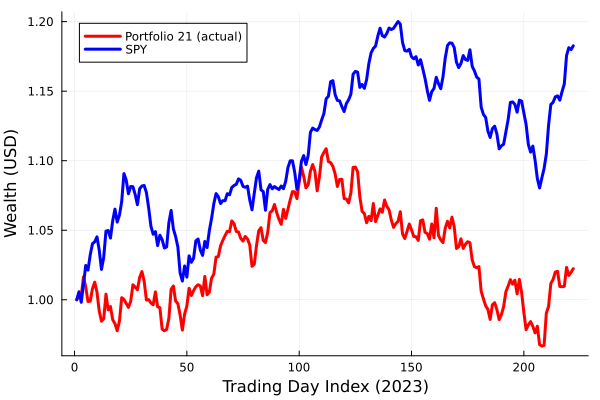

In [19]:
plot((1/portfolio_performance_array[1,end]).*portfolio_performance_array[:,end], lw=3, 
    c=:red, label="Portfolio $(portfolio_index) (actual)")
plot!((1/SPY_df[1,:volume_weighted_average_price]).*SPY_df[:,:volume_weighted_average_price], lw=3, 
    c=:blue, label="SPY")
xlabel!("Trading Day Index (2023)", fontsize=18)
ylabel!("Wealth (USD)", fontsize=18)

## Task 4: Compute the allocation drift of portfolio $\mathcal{P}$

In [20]:
drift_array = Array{Float64,2}(undef, number_of_days, length(w))
for i ∈ 1:number_of_days
    
    total_portfolio_value = portfolio_performance_array[i,end];
    for j ∈ eachindex(my_list_of_tickers)
        drift_array[i,j] = (1/total_portfolio_value).*portfolio_performance_array[i,j]
    end
end

In [21]:
drift_array

222×6 Matrix{Float64}:
 0.184171  0.534647  0.133382  0.0  0.0  0.1478
 0.179768  0.539197  0.132993  0.0  0.0  0.148042
 0.177766  0.545123  0.129993  0.0  0.0  0.147118
 0.179588  0.546522  0.126854  0.0  0.0  0.147036
 0.175348  0.535338  0.139237  0.0  0.0  0.150077
 0.172045  0.53704   0.139774  0.0  0.0  0.151141
 0.170569  0.53562   0.141072  0.0  0.0  0.152739
 0.169061  0.535154  0.143251  0.0  0.0  0.152534
 0.170254  0.534116  0.143591  0.0  0.0  0.152039
 0.165607  0.533435  0.147307  0.0  0.0  0.153651
 0.164285  0.532741  0.148658  0.0  0.0  0.154316
 0.16457   0.53892   0.14312   0.0  0.0  0.15339
 0.164385  0.536808  0.14439   0.0  0.0  0.154416
 ⋮                                       ⋮
 0.110088  0.498895  0.223846  0.0  0.0  0.167171
 0.111102  0.495124  0.227167  0.0  0.0  0.166607
 0.110491  0.496037  0.227107  0.0  0.0  0.166366
 0.110115  0.494223  0.229606  0.0  0.0  0.166057
 0.108783  0.494844  0.230298  0.0  0.0  0.166075
 0.106792  0.49177   0.234027  0.0  0

In [22]:
column_name_array = Array{String,1}();
for ticker ∈ my_list_of_tickers
    push!(column_name_array, ticker);
end
df = DataFrame(drift_array, column_name_array)

Row,PFE,MRK,AMD,MU,INTC,SPY
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.184171,0.534647,0.133382,0.0,0.0,0.1478
2,0.179768,0.539197,0.132993,0.0,0.0,0.148042
3,0.177766,0.545123,0.129993,0.0,0.0,0.147118
4,0.179588,0.546522,0.126854,0.0,0.0,0.147036
5,0.175348,0.535338,0.139237,0.0,0.0,0.150077
6,0.172045,0.53704,0.139774,0.0,0.0,0.151141
7,0.170569,0.53562,0.141072,0.0,0.0,0.152739
8,0.169061,0.535154,0.143251,0.0,0.0,0.152534
9,0.170254,0.534116,0.143591,0.0,0.0,0.152039


## Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.